In [1]:
import librosa
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Conv1D, Bidirectional, BatchNormalization, Flatten, Dense, CuDNNLSTM, TimeDistributed, Reshape, RepeatVector, MaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [2]:
charset = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

In [3]:
SR = 16000

In [4]:
DATA_DIR = "D:\\captchas\\len8-20k-audio"

In [21]:
files = os.listdir(DATA_DIR)

In [32]:
X_train = []
y_train = []

In [33]:
for file in files:
    try:
        wav, sr = librosa.load(DATA_DIR + "\\" + file, sr=SR, mono=True)
    except:
        continue
        
    file = file[:-4]
    X_train.append(wav)
    y_sample = np.zeros((8, 36))
    for i, ch in enumerate(file):        
        idx = charset.find(ch)
        y_sample[i] = np.eye(36)[idx]
    y_train.append(y_sample)

In [35]:
len(X_train)

19881

In [95]:
X_train = pad_sequences(X_train, maxlen=3*SR, padding='post', truncating='post', value=0)

In [45]:
y_train = np.array(y_train)

In [36]:
with open("F:\\xtrain.pickle", "wb") as fh:
    pickle.dump(X_train,fh)

In [7]:
with open("ytrain20k.pickle", "rb") as fh:
    y_train = pickle.load(fh)

In [6]:
with open("xtrain.pickle", "rb") as fh:
    X_train = pickle.load(fh)

In [13]:
import librosa.display
from librosa.feature import melspectrogram

In [30]:
X_train_spectros = []
for sample in X_train: 
  X_train_spectros.append(librosa.feature.melspectrogram(y=sample, sr=SR)) #, n_mels=128, fmax=8000)

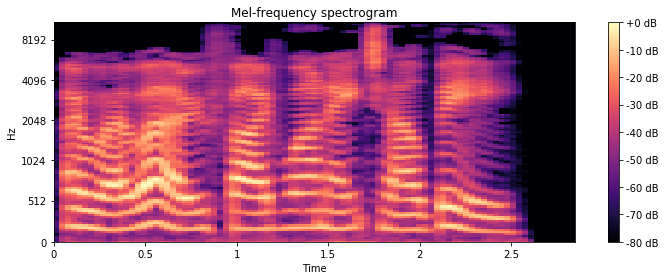

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=SR)#, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

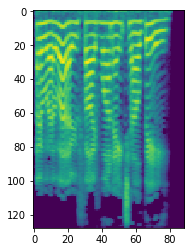

In [25]:
plt.imshow(S_dB)

In [67]:
X_train_ds = [scipy.signal.resample(sample.reshape((1,-1)), 20000, axis=1) for sample in X_train]

In [26]:
S.shape

(128, 89)

In [27]:
from PIL import Image
Image.fromarray(img).save("image.PNG")

ModuleNotFoundError: No module named 'PIL'

In [31]:
import matplotlib

matplotlib.image.imsave('name2.png', S_dB)

In [71]:
X_train_ds = np.array(X_train_ds)

In [73]:
X_train_ds = X_train_ds.squeeze()

In [86]:
inp = Input(shape=(20000, ))
x = Reshape(target_shape=(20000, 1))(inp)
x = CuDNNLSTM(32, return_sequences=True)(x) 
x = Dropout(0.2)(x) 
x = Bidirectional(CuDNNLSTM(1, return_sequences=True))(x) 
x = Flatten()(x)
x = Dense(64)(x)
x = RepeatVector(8)(x)
x = TimeDistributed(Dense(36))(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [78]:
VAL_DATA_DIR = "D:\\captchas\\len8-audio-val"
SR = 16000

In [79]:
files = os.listdir(VAL_DATA_DIR)

In [80]:
X_val = []
y_val = []

In [81]:
for file in files:
    try:
        wav, sr = librosa.load(VAL_DATA_DIR + "\\" + file, sr=SR, mono=True)
        wav = scipy.signal.resample(wav, 20000)
    except:
        continue
        
    file = file[:-4]
    X_val.append(wav)
    y_sample = np.zeros((8, 36))
    for i, ch in enumerate(file):        
        idx = charset.find(ch)
        y_sample[i] = np.eye(36)[idx]
    y_val.append(y_sample)

In [82]:
X_val = np.array(X_val)

In [83]:
y_val = np.array(y_val)

In [87]:
curr_time = str(int(time.time()))
check_point = ModelCheckpoint("F:\\"+curr_time+'.hdf5',verbose=True, save_best_only=True)
tensorboard_cb = TensorBoard(log_dir='/Graph', histogram_freq=0, write_graph=True, write_images=True)
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=True, restore_best_weights=True)
model.fit(X_train_ds, y_train, epochs=16, batch_size=32, validation_data=(X_val,y_val), verbose=1, callbacks=[tensorboard_cb, check_point, early_stop])

Train on 19881 samples, validate on 6504 samples
Epoch 1/16
 4992/19881 [======>.......................] - ETA: 29:53 - loss: 8.1979 - acc: 0.0257

KeyboardInterrupt: 

In [90]:
inp = Input(shape=(20000, ))
x = Reshape(target_shape=(20000, 1))(inp)
x = Conv1D(32, 3)(x) 
x = BatchNormalization()(x) 
x = MaxPool1D(3)(x)
x = Conv1D(32, 3)(x) 
x = Flatten()(x)
x = Dense(64)(x)
x = RepeatVector(8)(x)
x = TimeDistributed(Dense(36))(x)
model1 = Model(inputs=inp, outputs=x)
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [93]:
curr_time = str(int(time.time()))
check_point = ModelCheckpoint("F:\\"+curr_time+'.hdf5',verbose=True, save_best_only=True)
tensorboard_cb = TensorBoard(log_dir='/Graph', histogram_freq=0, write_graph=True, write_images=True)
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=True, restore_best_weights=True)
model1.fit(X_train_ds, y_train, epochs=16, batch_size=32, validation_data=(X_val,y_val), verbose=1, callbacks=[tensorboard_cb, check_point, early_stop])

Train on 19881 samples, validate on 6504 samples
Epoch 1/16
19872/19881 [============================>.] - ETA: 0s - loss: 8.7680 - acc: 0.0242
Epoch 00001: val_loss improved from inf to 7.59409, saving model to F:\1571101978.hdf5
19881/19881 [==============================] - 96s 5ms/sample - loss: 8.7671 - acc: 0.0242 - val_loss: 7.5941 - val_acc: 0.0207
Epoch 2/16
19872/19881 [============================>.] - ETA: 0s - loss: 8.8732 - acc: 0.0242
Epoch 00002: val_loss did not improve from 7.59409
19881/19881 [==============================] - 74s 4ms/sample - loss: 8.8737 - acc: 0.0242 - val_loss: 8.6275 - val_acc: 0.0207
Epoch 3/16
19872/19881 [============================>.] - ETA: 0s - loss: 8.7697 - acc: 0.0242
Epoch 00003: val_loss did not improve from 7.59409
Restoring model weights from the end of the best epoch.
19881/19881 [==============================] - 72s 4ms/sample - loss: 8.7697 - acc: 0.0242 - val_loss: 8.5723 - val_acc: 0.0207
Epoch 00003: early stopping


In [93]:
del model

In [99]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 20000)             0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 20000, 1)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 19998, 32)         128       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 19998, 32)         128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6666, 32)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 6664, 32)          3104      
_________________________________________________________________
flatten_10 (Flatten)         (None, 213248)            0         
__________

In [7]:
from scipy import signal

In [8]:
X_train1[0]

array([0, 0, 0, ..., 0, 0, 0])

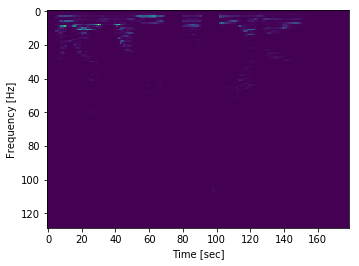

In [41]:
frequencies, times, spectrogram = signal.spectrogram(X_train[2], SR)

plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [44]:
spectrogram

array([[0.00000000e+00, 0.00000000e+00, 2.56939161e-14, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.25692955e-14, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.25981218e-14, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 7.40028139e-19, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.35254047e-19, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.65497916e-20, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], dtype=float32)

In [39]:
spectrogram.shape

(129, 202)

In [16]:
sum(sum(X_train1))

0

In [18]:
sum(sum(X_train2))

0